# Machine Learning Notebook: NBA Team Statistics

Goal:
 - Explore the NBA Team Statistic dataset
 - Explore possible machine learning models to predict future SRS for each team.
 - Generate several data visualizations using the NBA Statistic dataset. 

## Data Exploration/Preparation

### Data Exploration

In [1]:
# Import neccesary libraries.
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

In [2]:
NBA_init = pd.read_csv("NBA.csv")
print(NBA_init.shape)
NBA_init.head()

(330, 10)


,Unnamed: 0,Name,Win,Lost,Win Rate,Game Behind,Points Per Game,Opponent Points Per Game,Simple Rating System(SRS),Year
0,0,Toronto Raptors,48,34,0.585,—,101.3,98.0,2.55,2014
1,1,Brooklyn Nets,44,38,0.537,4.0,98.5,99.5,-1.58,2014
2,2,New York Knicks,37,45,0.451,11.0,98.6,99.4,-1.40,2014
3,3,Boston Celtics,25,57,0.305,23.0,96.2,100.7,-4.97,2014
4,4,Philadelphia 76ers,19,63,0.232,29.0,99.5,109.9,-10.66,2014


The NBA team statistic dataset contains 330 records with 10 attributes. However, the first attribute are meaningless and should be dropped. 

In [3]:
# Addressing the first meaningless column
NBA_sec = NBA_init.drop(NBA_init.columns[0], axis=1)
print(NBA_sec.shape)
NBA_sec.head()

(330, 9)


,Name,Win,Lost,Win Rate,Game Behind,Points Per Game,Opponent Points Per Game,Simple Rating System(SRS),Year
0,Toronto Raptors,48,34,0.585,—,101.3,98.0,2.55,2014
1,Brooklyn Nets,44,38,0.537,4.0,98.5,99.5,-1.58,2014
2,New York Knicks,37,45,0.451,11.0,98.6,99.4,-1.40,2014
3,Boston Celtics,25,57,0.305,23.0,96.2,100.7,-4.97,2014
4,Philadelphia 76ers,19,63,0.232,29.0,99.5,109.9,-10.66,2014


In [4]:
# Check missing values. 
print(NBA_sec.isnull().sum())

Name                         0
Win                          0
Lost                         0
Win Rate                     0
Game Behind                  0
Points Per Game              0
Opponent Points Per Game     0
Simple Rating System(SRS)    0
Year                         0
dtype: int64


The NBA Statistic dataset doesn't seem to contain any missing values, but some of the teams are missing "Game Behind" value because there's no game behind for those teams. Therefore, it's important to replace those placeholders as 0 to make sure all values are numerical. 

In [5]:
# Dealing with space holders
temp = 0
while temp <= len(NBA_sec) - 1:
    if NBA_sec.iloc[temp][4] == "—":
        NBA_sec.at[temp, "Game Behind"] = 0.0
    temp += 1

# Check for accuracy
NBA_sec.isin(["—"]).sum()

Name                         0
Win                          0
Lost                         0
Win Rate                     0
Game Behind                  0
Points Per Game              0
Opponent Points Per Game     0
Simple Rating System(SRS)    0
Year                         0
dtype: int64

In [6]:
NBA_sec.head()

,Name,Win,Lost,Win Rate,Game Behind,Points Per Game,Opponent Points Per Game,Simple Rating System(SRS),Year
0,Toronto Raptors,48,34,0.585,0.0,101.3,98.0,2.55,2014
1,Brooklyn Nets,44,38,0.537,4.0,98.5,99.5,-1.58,2014
2,New York Knicks,37,45,0.451,11.0,98.6,99.4,-1.40,2014
3,Boston Celtics,25,57,0.305,23.0,96.2,100.7,-4.97,2014
4,Philadelphia 76ers,19,63,0.232,29.0,99.5,109.9,-10.66,2014


In [7]:
NBA_sec.to_csv("NBA_dashboard.csv")

### Summary Table

In [8]:
NBA_sec.describe()

,Win,Lost,Win Rate,Points Per Game,Opponent Points Per Game,Simple Rating System(SRS),Year
count,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.00000
mean,40.027273,40.027273,0.499524,108.191212,108.205455,-0.015485,2019.00000
std,12.114042,11.931766,0.147733,6.353140,6.248304,4.595238,3.16708
min,10.000000,9.000000,0.122000,91.900000,91.800000,-10.660000,2014.00000
25%,32.000000,31.000000,0.402000,103.425000,103.825000,-3.057500,2016.00000
50%,42.000000,39.000000,0.512000,108.500000,108.400000,0.330000,2019.00000
75%,49.000000,49.000000,0.610000,113.400000,112.775000,3.035000,2022.00000
max,73.000000,72.000000,0.890000,123.300000,123.100000,11.350000,2024.00000


### Scatter Plot Matrix

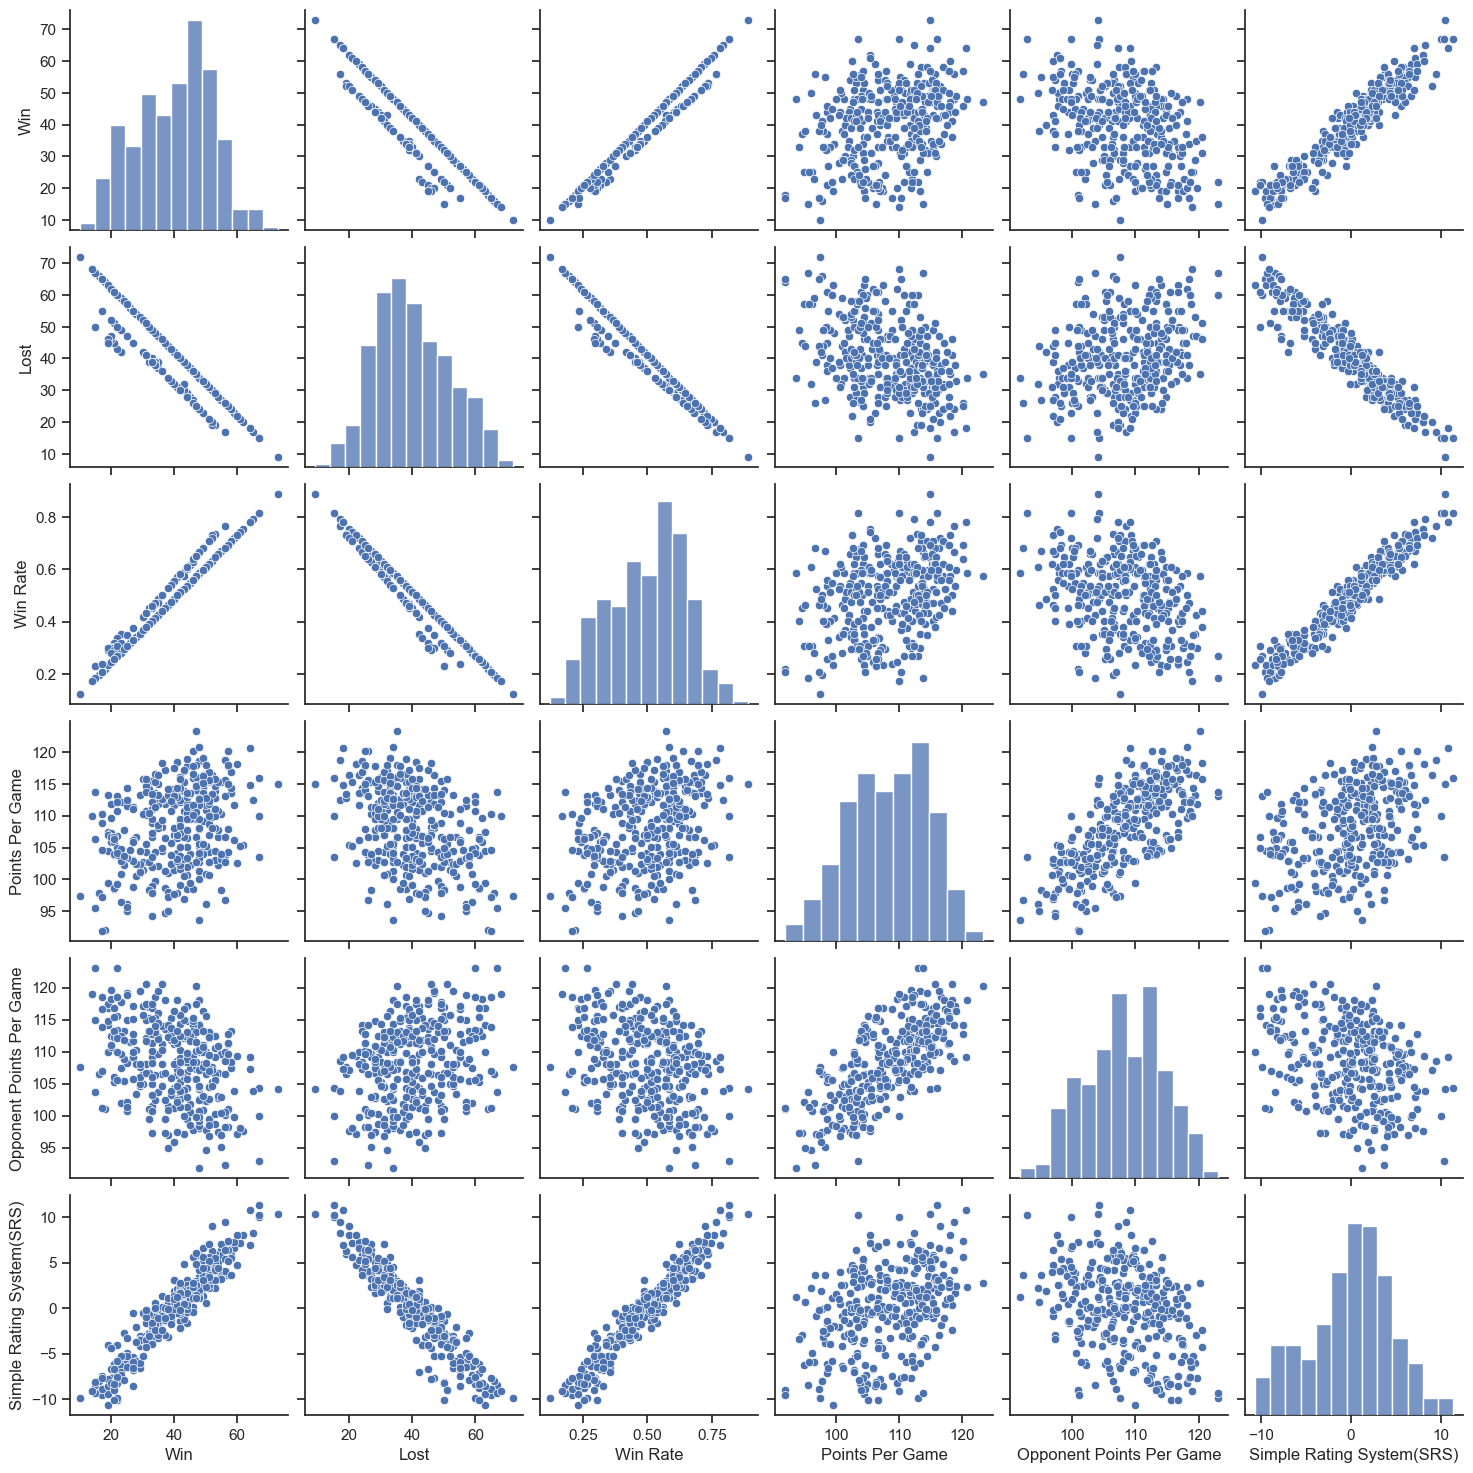

In [9]:
sns.set_theme(style="ticks")
sns.pairplot(NBA_sec,
             x_vars=["Win", "Lost", "Win Rate", "Points Per Game", "Opponent Points Per Game", "Simple Rating System(SRS)"],
             y_vars=["Win", "Lost", "Win Rate", "Points Per Game", "Opponent Points Per Game", "Simple Rating System(SRS)"])

Based on the scatter plot matrix, it's clear that many variables are correlated with each other. Which probably will lead to a muticollinearity issue in the model. 

In [10]:
# Create input and output vectors
features = ["Win", "Lost", "Win Rate", "Points Per Game", "Opponent Points Per Game"]
X = NBA_sec.loc[:, features]
y = NBA_sec.loc[:, ["Simple Rating System(SRS)"]]

# Check VIF of each variable
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i)
              for i in range(len(X.columns))]
print(vif)

                    feature          VIF
0                       Win   664.473058
1                      Lost   125.455933
2                  Win Rate  1014.406205
3           Points Per Game  7315.175154
4  Opponent Points Per Game  7152.493070


The Variance Inflation Factor(VIF) of the feature variables are much higher than expected. Let's do some feature selection by applying Principle Component Analysis (PCA) to the data. 

### PCA

In [11]:
# Train/Testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train) # Make sure to only scale the input vectors. 
X_test_scaled = scaler.transform(X_test)

In [18]:
# Apply PCA to the data
pca = PCA(n_components=2, random_state=199)
pca.fit(X_train_scaled)

X_train_PCA = pca.transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)

# The amount of variance explained by the first two component of PCA
sum(pca.explained_variance_ratio_)

0.9843994391909439

In [19]:
# Their corresponding ratio.
pca.explained_variance_ratio_

array([0.64415908, 0.34024036])

## Machine Learning
 - Test/Training split is already done with the PCA Step.
 - Will be trying three separate regression models: Simple Linear Regression, Random Forest Regression, and AdaBoosting method. 

In [20]:
def calculate_RMSE(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return round(mse ** 1/2,3)

### Multiple Linear Regression

In [21]:
SLR = LinearRegression()
SLR.fit(X_train_PCA, y_train)
RMSE = calculate_RMSE(SLR, X_test_PCA, y_test)
print(f'The RMSE value for the Multiple Linear Regression Model is {RMSE}')

The RMSE value for the Multiple Linear Regression Model is 0.462


### Random Forest Regression

In [22]:
RFR = RandomForestRegressor()
RFR.fit(X_train_PCA, y_train.values.ravel())
RMSE = calculate_RMSE(RFR, X_test_PCA, y_test)
print(f'The RMSE value for the Random Forest Regression Model is {RMSE}')

The RMSE value for the Random Forest Regression Model is 0.577


In [23]:
# Trying tuning Hyperparameter
RFR_tune = RandomForestRegressor()
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1,20)
}

rand_search = RandomizedSearchCV(RFR_tune, param_distributions= param_dist, n_iter=10, cv=5, random_state=42)

# Fit the random search object to the data.
rand_search.fit(X_train_PCA, y_train.values.ravel())
rand_search.best_estimator_

RandomForestRegressor(max_depth=4, n_estimators=409)

In [24]:
# Create the Random Forest model using the best parameters.
Best_RFR = RandomForestRegressor(max_depth=4, n_estimators=409)
Best_RFR.fit(X_train_PCA, y_train.values.ravel())
RMSE = calculate_RMSE(Best_RFR, X_test_PCA, y_test)
print(f'The RMSE value for the Random Forest Regression Model is {RMSE}')

The RMSE value for the Random Forest Regression Model is 0.493


### AdaBoosting

In [25]:
ADA = AdaBoostRegressor()
ADA.fit(X_train_PCA, y_train.values.ravel())
RMSE = calculate_RMSE(ADA, X_test_PCA, y_test)
print(f'The RMSE value for the AdaBoosting Regression Model is {RMSE}')

The RMSE value for the AdaBoosting Regression Model is 0.522


In [26]:
# Trying tuning Hyperparameter
ADA_tune = AdaBoostRegressor()

param_grid = {
    "n_estimators": [i for i in range(2,13,1)],
    "learning_rate": [(0.97 + x / 100) for x in range(0,8)]
}

ADA_gscv = GridSearchCV(ADA_tune, param_grid, cv=5, n_jobs=1)
ADA_gscv.fit(X_train_PCA, y_train.values.ravel())
ADA_gscv.best_estimator_

AdaBoostRegressor(learning_rate=0.98, n_estimators=4)

In [27]:
Best_ADA = AdaBoostRegressor(learning_rate=0.98, n_estimators=4)
Best_ADA.fit(X_train_PCA, y_train.values.ravel())
RMSE = calculate_RMSE(Best_ADA, X_test_PCA, y_test)
print(f'The RMSE value for the AdaBoosting Regression Model is {RMSE}')

The RMSE value for the AdaBoosting Regression Model is 0.637


## Discussion

Surprisingly, among the three machine learning models, the multiple linear regression model performs the best in predicting the SRS (Simple Rating System) of different NBA teams when using the five statistics mentioned earlier. With a Root Mean Squared Error (RMSE) value of 0.462. This indicates that, on average, the model's predicted SRS values deviate from the actual SRS values by 0.462 points. On the other hand, while the use of Principal Component Analysis (PCA) helps prevent the multicollinearity problem, it fails to demonstrate the influence of each individual feature.